In [21]:
%load_ext autoreload 
%autoreload 2

import sys
sys.path.append('../')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv(), override=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from deepeval.metrics import FaithfulnessMetric, ContextualRelevancyMetric, BaseMetric, GEval
from deepeval.test_case import LLMTestCase
from deepeval import evaluate
from deepeval.models import DeepEvalBaseLLM
from src.evaluation.llm_evaluation import (CustomAzureOpenAI, AnswerCorrectnessMetric, EvalResponse, load_eval_response) #, TestCaseBundle)
from src.database.weaviate_interface_v4 import WeaviateWCS
from src.database.database_utils import get_weaviate_client
from src.preprocessor.preprocessing import FileIO
from src.reranker import ReRanker
from src.llm.prompt_templates import context_block, create_context_blocks
from src.llm.llm_interface import LLM
from src.llm.llm_utils import load_azure_openai
from src.llm.prompt_templates import (huberman_system_message, question_answering_prompt_series,
                                     create_context_blocks, generate_prompt_series)
from litellm import model_cost

from loguru import logger
from random import sample
from tqdm import tqdm
from typing import Callable
from tqdm.asyncio import tqdm_asyncio
import asyncio
import nest_asyncio
nest_asyncio.apply()

### Review list of models by cost

In [10]:
def get_sortable_model_cost(model_cost_dict: dict) -> list[dict]:
    '''
    Converts a dict of dicts into a list of dicts of model names 
    and their metadata.  Only return models with an 
    'input_cost_per_token' key
    '''
    sortable = []
    for k,v in model_cost_dict.items():
        model_dict = {'model': k}
        if 'input_cost_per_token' in v:
            sortable.append({**model_dict, **v})
    return sortable

In [11]:
models = get_sortable_model_cost(model_cost)

In [12]:
# models

### Load Test Case data

In [13]:
data_path = '../data/golden_datasets/llm_eval_testcases_initial.json'
test_case_data = FileIO().load_json(data_path)
baseline_test_cases = [LLMTestCase(**data) for data in test_case_data]

### Overview of ContextualRelevancy metric

![Context Relevancy]( 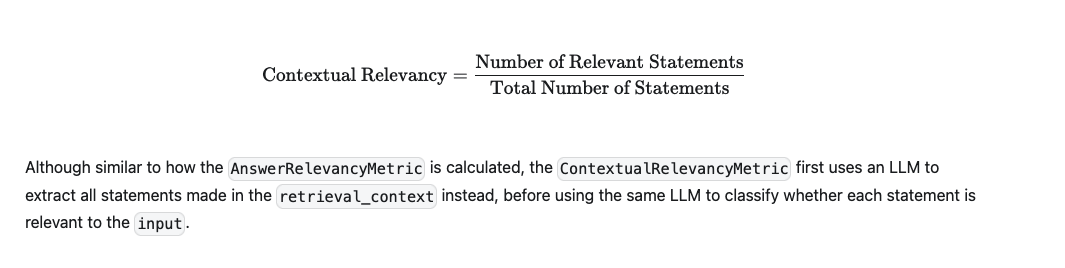)

### Define Async Eval Function Calls

In [40]:
async def context_relevancy_async(test_case: LLMTestCase,
                                  model: str | DeepEvalBaseLLM
                                  ) -> EvalResponse:
    metric = ContextualRelevancyMetric(model=model)
    await metric.a_measure(test_case)
    response = load_eval_response(metric, test_case)
    return response

In [41]:
async def answer_correctness_async(test_case: LLMTestCase,
                                   model: str | DeepEvalBaseLLM
                                   ) -> EvalResponse:
    metric = AnswerCorrectnessMetric(model=model)
    await metric.a_measure(test_case)
    response = load_eval_response(metric, test_case)
    return response

In [43]:
async def async_evaluation(test_cases: list[LLMTestCase],
                           model: str | DeepEvalBaseLLM,
                           async_metric_call: Callable
                           ) -> list[EvalResponse]:
    tasks = [async_metric_call(case, model) for case in test_cases]
    responses = await tqdm_asyncio.gather(*tasks)
    return responses

### Insert either context_relevancy or answer_correctness function calls

In [48]:
eval_model = 'gpt-4-turbo-preview'

responses = await async_evaluation(baseline_test_cases, eval_model, context_relevancy_async)

In [49]:
# print(response[0])
# print(responses[0].__dict__)

### Extract Scores and Reasons

In [16]:
scores = [r.score for r in responses]
reasons = [r.reason for r in responses]